#### Курс "Машинное обучение в бизнесе" ДЗ 2

<b>Задание</b>
1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [1]:
import pandas as pd

Наши новости

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [4]:
#pip install gensim

In [5]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [6]:
#pip install razdel

In [7]:
#pip install pymorphy2

In [8]:
#import nltk
#nltk.download('stopwords')

In [9]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [10]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [11]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [12]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [13]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

C:\Users\EF10~1\AppData\Local\Temp/ipykernel_3620/3066725202.py:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 38 s


In [14]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 4min 10s


А теперь в 3 строчки обучим нашу модель

In [15]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [16]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [17]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 47 s


In [18]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [19]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(8, 0.42352444),
 (11, 0.08478708),
 (12, 0.022282645),
 (16, 0.07748022),
 (20, 0.27340102),
 (23, 0.10154398)]

In [20]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: турецкий парк миля шотландия датский покой охарактеризовать
topic_1: фонд рубль год тыс писать ставка размер
topic_2: ребёнок гражданин человек смерть женщина взрыв препарат
topic_3: мозг выяснить доклад лечение компания больница воздух
topic_4: украина украинский киев украинец донбасс дневный киевский
topic_5: год который россия nn это также российский
topic_6: суд операция это президент закон правительство дело
topic_7: сша американский компания год китай который это
topic_8: это год который мочь свой всё большой
topic_9: снижение остров университет британский страдать особенность японский
topic_10: банк статья экономика nn россиянин гражданин рейтинг
topic_11: год млн газ составить общий контракт тыс
topic_12: запустить устойчивый диск запуск гарантия понятие существо
topic_13: следствие свидетель тепло разделение ричард радикальный явиться
topic_14: тело жертва популярный убить бесплатный фильм кость
topic_15: форум развивающийся прирост умирать актуальный втб лесной
topic

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [21]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [22]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.062324,0.085251,0.0,0.00000,0.0
1,4896,0.0,0.0,0.240426,0.000000,0.0,0.0,0.00000,0.0,0.000000,...,0.0,0.000000,0.0,0.396374,0.000000,0.341182,0.000000,0.0,0.00000,0.0
2,4897,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.423550,...,0.0,0.077479,0.0,0.000000,0.000000,0.273388,0.000000,0.0,0.10155,0.0
3,4898,0.0,0.0,0.000000,0.073472,0.0,0.0,0.00000,0.0,0.495692,...,0.0,0.000000,0.0,0.000000,0.032739,0.214142,0.078031,0.0,0.00000,0.0
4,4899,0.0,0.0,0.000000,0.000000,0.0,0.0,0.28836,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.199359,0.120738,0.290180,0.0,0.00000,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [23]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [24]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [25]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.031057  , 0.        ,
       0.36553219, 0.21692599, 0.        , 0.18931575, 0.        ,
       0.        , 0.06031349, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04600659, 0.        , 0.        , 0.05129326, 0.02923282])

<b> Используем медиану </b>

In [27]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [28]:
get_user_embedding_median(user_articles_list)

array([0.        , 0.00541368, 0.        , 0.        , 0.        ,
       0.16453351, 0.1746157 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.13779483, 0.        ,
       0.        , 0.21649135, 0.        , 0.        , 0.08439445])

In [29]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [30]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера сообщать риа новость nn читать сообщение разговаривать автор сообщение знать откуда автор источник какихлибо основание подобный род репортаж знать откуда информация появиться сказать журналист итог встреча госсекретарь сша джон керри nn позиция свой изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать свой безопасность счёт безопасность продолжить министр слово лавров москва считать система нато создавать проблема наш безопасность поэтому декларация недостаточно мочь договариваться совместный система россия предлагать ещё начинать год президент путин посещать сша нужно вести речь очередной декларация гарантия который проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенци

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [ ]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [32]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [36]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.000000,0.000000,0.006296,0.000000,0.337554,0.034416,0.000000,0.000000,...,0.0,0.015763,0.104644,0.0,0.000000,0.000000,0.00000,0.025647,0.014616,0
1,u108690,0.0,0.019769,0.005478,0.000000,0.018929,0.108446,0.037711,0.000000,0.065176,...,0.0,0.000000,0.180137,0.0,0.017518,0.250045,0.00000,0.032796,0.024627,1
2,u108339,0.0,0.000000,0.034493,0.014499,0.000000,0.138478,0.079515,0.009997,0.020538,...,0.0,0.000000,0.287218,0.0,0.000000,0.151360,0.00716,0.059871,0.047945,1


In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [52]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [53]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [54]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.19820663, 0.02573093, 0.28556586, 0.19692264, 0.00804794,
       0.04241122, 0.14154627, 0.03057139, 0.02698674, 0.07072058])

In [55]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [58]:
precision_median, recall_median, thresholds_median = precision_recall_curve(y_test, preds)
fscore_median = (2 * precision_median * recall_median) / (precision_median + recall_median)
# locate the index of the largest f score
ix = np.argmax(fscore_median)
print('Best Threshold_median=%f, F-Score_median=%.3f, Precision_median=%.3f, Recall_median=%.3f' % (thresholds_median[ix], 
                                                                                                    fscore_median[ix],
                                                                                                    precision_median[ix],
                                                                                                    recall_median[ix]))

Best Threshold_median=0.238755, F-Score_median=0.688, Precision_median=0.601, Recall_median=0.804


In [59]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1624  131]
 [  49  196]]


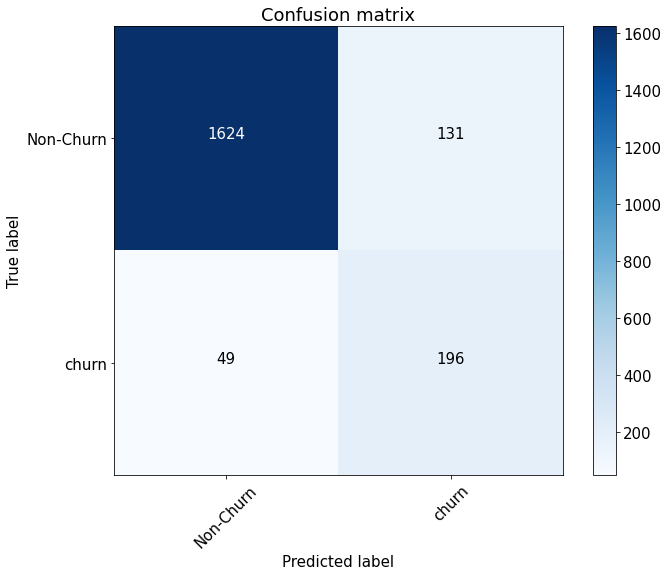

In [60]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds_median[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_median.png")
plt.show()

In [61]:
median_roc_auc = roc_auc_score(y_test, preds)
median_roc_auc

0.9444060701203559

<b>Используем максимум</b> 

In [62]:
#user_articles_list = users['articles'].iloc[33] --определяли ранее для median

def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [63]:
get_user_embedding_median(user_articles_list)

array([0.        , 0.00541368, 0.        , 0.        , 0.        ,
       0.16453351, 0.1746157 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.13779483, 0.        ,
       0.        , 0.21649135, 0.        , 0.        , 0.08439445])

Получаем эмбендинги для всех пользователей

In [64]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.183701,0.168749,0.124800,0.217142,0.630542,0.216926,0.134032,0.189316,...,0.0,0.145640,0.062161,0.220618,0.116121,0.046007,0.330889,0.027213,0.127663,0.100173
1,u108690,0.0,0.139211,0.077835,0.011888,0.114747,0.231757,0.150278,0.058502,0.155514,...,0.0,0.013662,0.052230,0.377125,0.000000,0.067809,0.541974,0.000000,0.153586,0.058953
2,u108339,0.0,0.047060,0.113177,0.069272,0.000000,0.188797,0.255217,0.075662,0.047086,...,0.0,0.018972,0.095456,0.365951,0.000000,0.000000,0.290038,0.039991,0.143227,0.102927


In [65]:
# все переменные переопределяются, кроме precision, recall, thresholds и f_score
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.183701,0.168749,0.124800,0.217142,0.630542,0.216926,0.134032,0.189316,...,0.145640,0.062161,0.220618,0.116121,0.046007,0.330889,0.027213,0.127663,0.100173,0
1,u108690,0.0,0.139211,0.077835,0.011888,0.114747,0.231757,0.150278,0.058502,0.155514,...,0.013662,0.052230,0.377125,0.000000,0.067809,0.541974,0.000000,0.153586,0.058953,1
2,u108339,0.0,0.047060,0.113177,0.069272,0.000000,0.188797,0.255217,0.075662,0.047086,...,0.018972,0.095456,0.365951,0.000000,0.000000,0.290038,0.039991,0.143227,0.102927,1


In [66]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [67]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [68]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.1857921 , 0.00143973, 0.76116731, 0.13929631, 0.03527005,
       0.00245945, 0.17535667, 0.05303735, 0.00589162, 0.05402309])

### Рассчитаем Precision, Recall, F_score для  max

In [70]:
precision_max, recall_max, thresholds_max = precision_recall_curve(y_test, preds)
fscore_max = (2 * precision_max * recall_max) / (precision_max + recall_max)
# locate the index of the largest f score
ix = np.argmax(fscore_max)
print('Best Threshold_max=%f, F-Score_max=%.3f, Precision_max=%.3f, Recall_max=%.3f' % (thresholds_max[ix], 
                                                                                        fscore_max[ix],
                                                                                        precision_max[ix],
                                                                                        recall_max[ix]))

Best Threshold_max=0.337224, F-Score_max=0.771, Precision_max=0.718, Recall_max=0.833


Confusion matrix, without normalization
[[1675   80]
 [  42  203]]


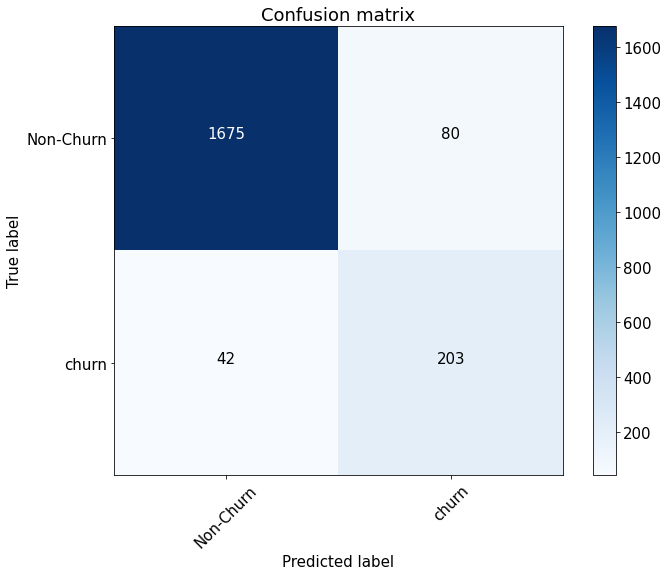

In [72]:
cnf_matrix = confusion_matrix(y_test, preds>thresholds_max[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_max.png")
plt.show()

In [73]:
max_roc_auc = roc_auc_score(y_test, preds)
max_roc_auc

0.9688540031397174

In [88]:
#из вебинара берем значения для mean
Threshold_mean=0.286357
FScore_mean=0.777
Precision_mean=0.741
Recall_mean=0.816
mean_roc_auc=0.97157

In [89]:
#тк большая часть переменных переопределялась, то выписала метрики отдельно

Threshold_median=0.238755
FScore_median=0.688
Precision_median=0.601
Recall_median=0.804
median_roc_auc=0.9444

Threshold_max=0.337224
FScore_max=0.771
Precision_max=0.718
Recall_max=0.833
max_roc_auc=0.96885

Не успела оформить это в табличку